In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import pmdarima as pm
import cvxpy
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

pd.options.mode.chained_assignment = None

In [2]:
def XOX(s, p):
    '''
    将绝对量数据转化为增长率 ( e.g. [1,2,3] -> [2,1.5,NA] )
    s : array
    p : look-back period
    '''
    return np.append((s[p:] - s[:-p])/s[:-p], np.repeat(np.nan, p))

def lagging(s, l):
    '''
    向前平移时间序列 ( e.g. [1,2,3] -> [2,3,NA] )
    s : array
    l : lagging period
    '''
    return np.append(s[l:], np.repeat(np.nan, l))

In [85]:
data = pd.read_csv('CONTEST_DATA_TEST_100_1.csv', header = None) \
    .append(pd.read_csv('data900-999.csv', header = None)).reset_index(drop = True)
data.rename(columns={0:'day', 
                     1:'stock', 
                     2:'open', 
                     3:'high', 
                     4:'low', 
                     5:'close', 
                     6:'volume', 
                     7:'moneyvolume'}, inplace=True)
data['close_chg_10'] = data[['stock', 'close']].groupby('stock').transform(lambda x: lagging(XOX(x.values, 10), 1))

In [86]:
data

,day,stock,open,high,low,close,volume,moneyvolume,8,9,...,99,100,101,102,103,104,105,106,107,close_chg_10
0,0.0,6000.0,60.90,61.17,59.57,59.70,2756306.0,1.659607e+08,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.008664
1,0.0,6001.0,16.13,16.21,16.04,16.13,2120886.0,3.421016e+07,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.007817
2,0.0,6002.0,138.29,138.81,134.84,135.53,4376392.0,5.935791e+08,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005265
3,0.0,6003.0,28.51,28.90,28.47,28.71,400276.0,1.144611e+07,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.042903
4,0.0,6004.0,33.40,34.64,33.40,34.19,799353.0,2.715962e+07,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.163368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,999.0,6495.0,19.50,19.79,19.44,19.47,1735455.0,3.412445e+07,0.231079,-0.288574,...,-0.710449,0.066162,-0.609375,-0.656738,-0.511719,0.488525,-0.243652,0.132324,0.470703,NaN
499996,999.0,6496.0,215.02,217.61,204.35,206.94,2360347.0,4.964025e+08,-0.670898,-1.409180,...,-0.710449,1.028320,-0.451172,-1.633789,-0.049194,-0.439697,0.124634,0.113281,0.969727,NaN
499997,999.0,6497.0,279.49,279.85,273.82,274.17,4349590.0,1.205561e+09,-0.274414,-0.496094,...,-0.710449,1.617188,-0.798828,0.314697,-0.207275,0.056641,-0.185913,0.075134,0.631348,NaN
499998,999.0,6498.0,4.54,4.54,4.29,4.50,9437928.0,4.267815e+07,1.121094,3.000000,...,0.510254,-0.657715,-0.229980,1.068359,0.770020,-0.505371,3.000000,0.073486,0.157349,NaN


In [5]:
# 一个问题：数据并不随时间均匀分布。故先乱序。

from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

data_shuf = shuffle(data, random_state = 2021)

y_train = data_shuf[(data['day'] < 500).values].dropna().close_chg_10.values
X_train = data_shuf[(data['day'] < 500).values].dropna().iloc[:,8:108].values
y_validate = data_shuf[((data['day'] >= 500) & (data['day'] < 800)).values].dropna().close_chg_10.values
X_validate = data_shuf[((data['day'] >= 500) & (data['day'] < 800)).values].dropna().iloc[:,8:108].values
y_test = data_shuf[(data['day'] >= 800).values].dropna().close_chg_10.values
X_test = data_shuf[(data['day'] >= 800).values].dropna().iloc[:,8:108].values

In [61]:
min_20 = 0
n = 0
all_num = []
for i in range(100):
    all_num.append(abs(np.corrcoef(X_train[:,i], y_train)[0][1]))
print(sorted(all_num)[:20])

[0.00053123444530804, 0.001230846268366211, 0.0034162285910559168, 0.003943468541683881, 0.00456172415382996, 0.005152520265726487, 0.00532060531571519, 0.005408967713264843, 0.005894743639234913, 0.006241755524629131, 0.006426982994849365, 0.006748784058504069, 0.006958294930180462, 0.006958994818799039, 0.007097890003857953, 0.00718511221747231, 0.007507632340467374, 0.007553355908415122, 0.007966463045661586, 0.008225785872011105]


In [119]:
ind = []
for i in range(100):
    if abs(np.corrcoef(X_train[:,i], y_train)[0][1]) < 0.008226:
        ind.append(i)
ind = np.array(ind) + 8
ind

array([ 11,  29,  32,  41,  42,  54,  60,  78,  81,  83,  86,  87,  88,
        94,  99, 102, 103, 104, 105, 107])

In [122]:
test_data = data.copy()
test_data.drop(ind, axis=1, inplace = True)
test_data

,day,stock,open,high,low,close,volume,moneyvolume,8,9,...,92,93,95,96,97,98,100,101,106,close_chg_10
0,0.0,6000.0,60.90,61.17,59.57,59.70,2756306.0,1.659607e+08,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.008664
1,0.0,6001.0,16.13,16.21,16.04,16.13,2120886.0,3.421016e+07,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.007817
2,0.0,6002.0,138.29,138.81,134.84,135.53,4376392.0,5.935791e+08,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005265
3,0.0,6003.0,28.51,28.90,28.47,28.71,400276.0,1.144611e+07,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.042903
4,0.0,6004.0,33.40,34.64,33.40,34.19,799353.0,2.715962e+07,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.163368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,999.0,6495.0,19.50,19.79,19.44,19.47,1735455.0,3.412445e+07,0.231079,-0.288574,...,-0.537109,1.742188,-1.051758,-1.057617,-0.208008,-0.948242,0.066162,-0.609375,0.132324,NaN
499996,999.0,6496.0,215.02,217.61,204.35,206.94,2360347.0,4.964025e+08,-0.670898,-1.409180,...,-1.035156,0.067566,0.557617,-0.935059,-1.377930,-0.763184,1.028320,-0.451172,0.113281,NaN
499997,999.0,6497.0,279.49,279.85,273.82,274.17,4349590.0,1.205561e+09,-0.274414,-0.496094,...,0.167969,0.067017,-1.051758,-0.953613,-1.174805,-1.133789,1.617188,-0.798828,0.075134,NaN
499998,999.0,6498.0,4.54,4.54,4.29,4.50,9437928.0,4.267815e+07,1.121094,3.000000,...,0.189819,-1.312500,1.486328,-0.542969,1.267578,1.271484,-0.657715,-0.229980,0.073486,NaN


In [135]:
test_data_shuf = shuffle(test_data, random_state = 2021)

y_train = test_data_shuf[(data['day'] < 500).values].dropna().close_chg_10.values
X_train = test_data_shuf[(data['day'] < 500).values].dropna().iloc[:,8:88].values
y_validate = test_data_shuf[((data['day'] >= 500) & (data['day'] < 800)).values].dropna().close_chg_10.values
X_validate = test_data_shuf[((data['day'] >= 500) & (data['day'] < 800)).values].dropna().iloc[:,8:88].values
y_test = test_data_shuf[(data['day'] >= 800).values].dropna().close_chg_10.values
X_test = test_data_shuf[(data['day'] >= 800).values].dropna().iloc[:,8:88].values

# linear model

In [136]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train, y_train)

# pickle.dump(lm, open('Model/linear_model.sav', 'wb'))

LinearRegression()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


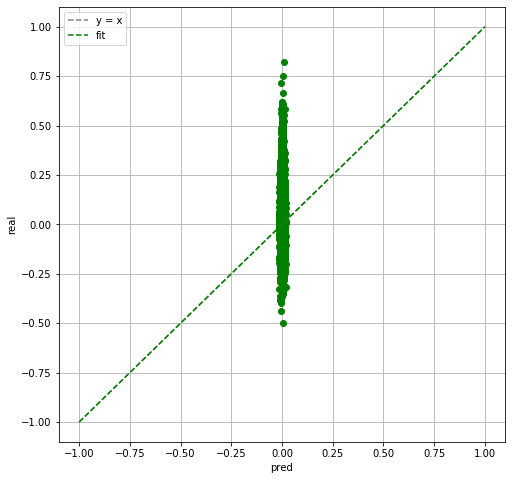

0.004268879207974966

In [137]:
y_train_pred = lm.predict(X_train)

plt.figure(figsize=(8, 8))
plt.plot(y_train_pred, y_train, 'go')
plt.plot([-1,1], [-1,1], 'grey', ls = '--', label = 'y = x')
plt.plot([-1,1], np.poly1d(np.polyfit(y_train_pred, y_train, 1))([-1,1]), 'g--', label = 'fit')
plt.xlabel('pred')
plt.ylabel('real')
plt.grid()
plt.legend()
plt.show()
mean_squared_error(y_train_pred, y_train)

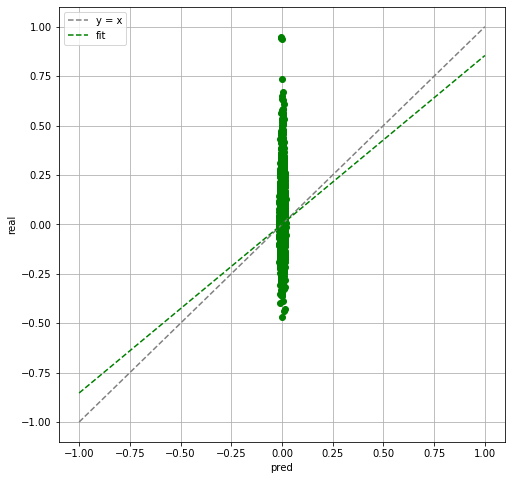

0.004334068932660705

In [138]:
y_validate_pred = lm.predict(X_validate)

plt.figure(figsize=(8, 8))
plt.plot(y_validate_pred, y_validate, 'go')
plt.plot([-1,1], [-1,1], 'grey', ls = '--', label = 'y = x')
plt.plot([-1,1], np.poly1d(np.polyfit(y_validate_pred, y_validate, 1))([-1,1]), 'g--', label = 'fit')
plt.xlabel('pred')
plt.ylabel('real')
plt.grid()
plt.legend()
plt.show()
mean_squared_error(y_validate_pred, y_validate)

# l2 linear model

In [139]:
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(X_train, y_train)

# pickle.dump(lm, open('Model/l2_linear_model.sav', 'wb'))

Ridge()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


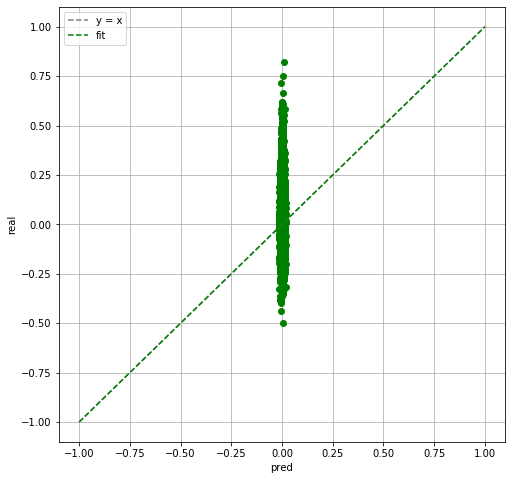

0.00426887920798831

In [140]:
y_train_pred = ridge.predict(X_train)

plt.figure(figsize=(8, 8))
plt.plot(y_train_pred, y_train, 'go')
plt.plot([-1,1], [-1,1], 'grey', ls = '--', label = 'y = x')
plt.plot([-1,1], np.poly1d(np.polyfit(y_train_pred, y_train, 1))([-1,1]), 'g--', label = 'fit')
plt.xlabel('pred')
plt.ylabel('real')
plt.grid()
plt.legend()
plt.show()
mean_squared_error(y_train_pred, y_train)

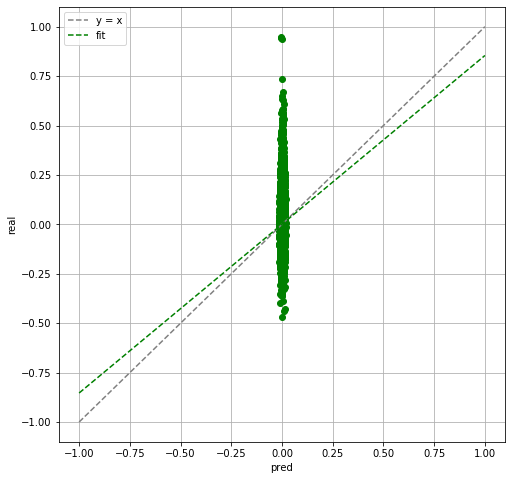

0.0043340688010848685

In [141]:
y_validate_pred = ridge.predict(X_validate)

plt.figure(figsize=(8, 8))
plt.plot(y_validate_pred, y_validate, 'go')
plt.plot([-1,1], [-1,1], 'grey', ls = '--', label = 'y = x')
plt.plot([-1,1], np.poly1d(np.polyfit(y_validate_pred, y_validate, 1))([-1,1]), 'g--', label = 'fit')
plt.xlabel('pred')
plt.ylabel('real')
plt.grid()
plt.legend()
plt.show()
mean_squared_error(y_validate_pred, y_validate)

# MLP

In [142]:
from sklearn.neural_network import MLPRegressor

hidden_layer_sizes = (80, 40, 20)
max_iter = 1000  # default = 20
alpha = 0.0001  # default = 0.0001
alpha = 0
learning_rate_init = 0.001  # default = 0.001

nnr = MLPRegressor(hidden_layer_sizes = hidden_layer_sizes, 
                   max_iter = max_iter, 
                   alpha = alpha, 
                   learning_rate_init = learning_rate_init, 
                   random_state = 2021)

nnr.fit(X_train, y_train)

# pickle.dump(nnr, open('Model/MLP_model_1.sav', 'wb'))

MLPRegressor(alpha=0, hidden_layer_sizes=(80, 40, 20), max_iter=1000,
             random_state=2021)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


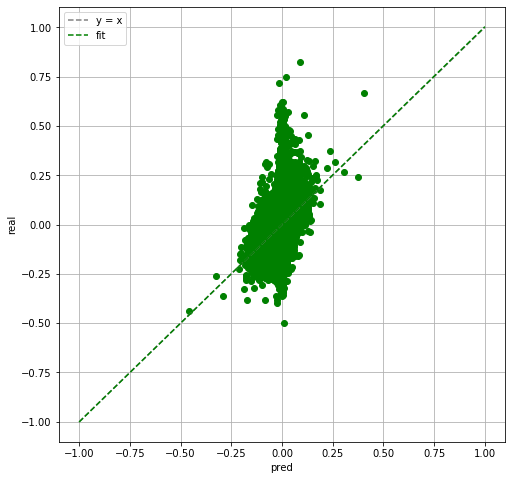

0.004045410521199267

In [143]:
y_train_pred = nnr.predict(X_train)

plt.figure(figsize=(8, 8))
plt.plot(y_train_pred, y_train, 'go')
plt.plot([-1,1], [-1,1], 'grey', ls = '--', label = 'y = x')
plt.plot([-1,1], np.poly1d(np.polyfit(y_train_pred, y_train, 1))([-1,1]), 'g--', label = 'fit')
plt.xlabel('pred')
plt.ylabel('real')
plt.grid()
plt.legend()
plt.show()
mean_squared_error(y_train_pred, y_train)

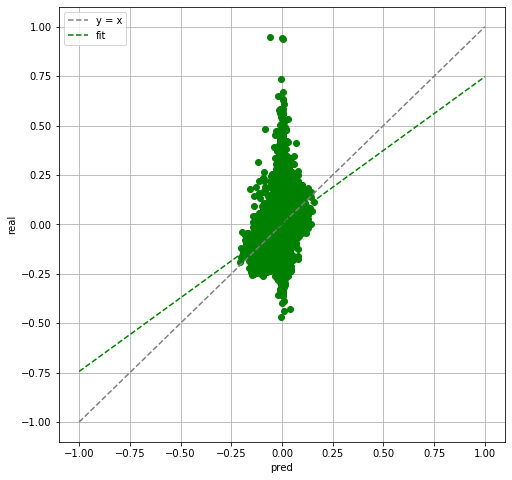

0.0042325933405568715

In [144]:
y_validate_pred = nnr.predict(X_validate)

plt.figure(figsize=(8, 8))
plt.plot(y_validate_pred, y_validate, 'go')
plt.plot([-1,1], [-1,1], 'grey', ls = '--', label = 'y = x')
plt.plot([-1,1], np.poly1d(np.polyfit(y_validate_pred, y_validate, 1))([-1,1]), 'g--', label = 'fit')
plt.xlabel('pred')
plt.ylabel('real')
plt.grid()
plt.legend()
plt.show()
mean_squared_error(y_validate_pred, y_validate)

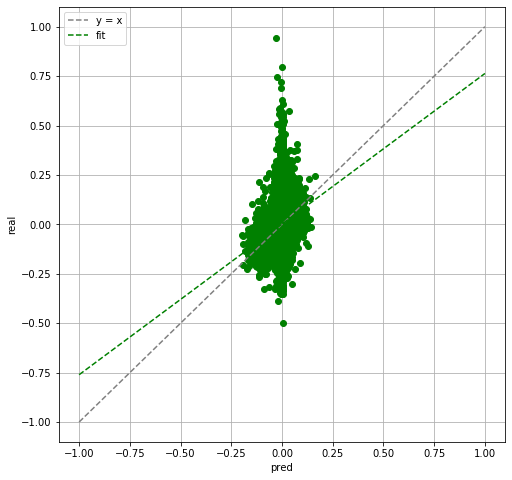

0.004270803790409136

In [145]:
y_test_pred = nnr.predict(X_test)

plt.figure(figsize=(8, 8))
plt.plot(y_test_pred, y_test, 'go')
plt.plot([-1,1], [-1,1], 'grey', ls = '--', label = 'y = x')
plt.plot([-1,1], np.poly1d(np.polyfit(y_test_pred, y_test, 1))([-1,1]), 'g--', label = 'fit')
plt.xlabel('pred')
plt.ylabel('real')
plt.grid()
plt.legend()
plt.show()
mean_squared_error(y_test_pred, y_test)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


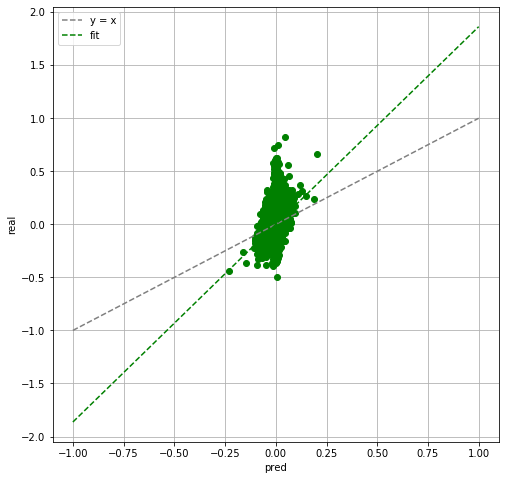

0.004100926064690938

In [146]:
y_train_pred_1 = ridge.predict(X_train)
y_train_pred_2 = nnr.predict(X_train)
y_train_pred = (y_train_pred_1 + y_train_pred_2) / 2


plt.figure(figsize=(8, 8))
plt.plot(y_train_pred, y_train, 'go')
plt.plot([-1,1], [-1,1], 'grey', ls = '--', label = 'y = x')
plt.plot([-1,1], np.poly1d(np.polyfit(y_train_pred, y_train, 1))([-1,1]), 'g--', label = 'fit')
plt.xlabel('pred')
plt.ylabel('real')
plt.grid()
plt.legend()
plt.show()
mean_squared_error(y_train_pred, y_train)

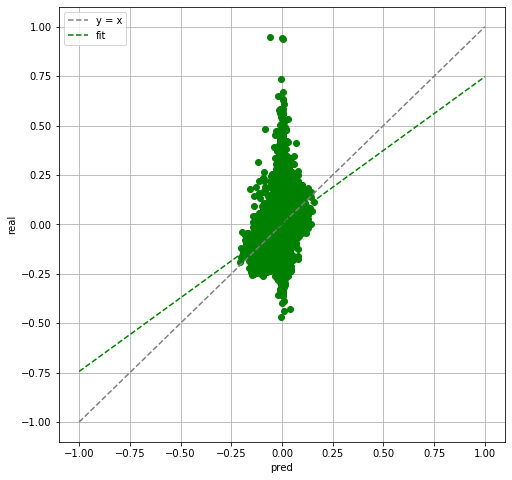

0.0042325933405568715

In [148]:
y_validate_pred_1 = ridge.predict(X_validate)
y_validate_pred_2 = nnr.predict(X_validate)
y_valid_pred = (y_validate_pred_1 + y_validate_pred_2) / 2

plt.figure(figsize=(8, 8))
plt.plot(y_validate_pred, y_validate, 'go')
plt.plot([-1,1], [-1,1], 'grey', ls = '--', label = 'y = x')
plt.plot([-1,1], np.poly1d(np.polyfit(y_validate_pred, y_validate, 1))([-1,1]), 'g--', label = 'fit')
plt.xlabel('pred')
plt.ylabel('real')
plt.grid()
plt.legend()
plt.show()
mean_squared_error(y_validate_pred, y_validate)

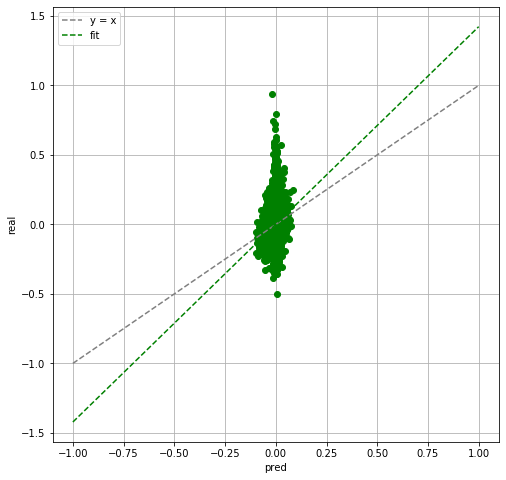

0.004271107886884318

In [149]:
y_test_pred_1 = ridge.predict(X_test)
y_test_pred_2 = nnr.predict(X_test)
y_test_pred = (y_test_pred_1 + y_test_pred_2) / 2

plt.figure(figsize=(8, 8))
plt.plot(y_test_pred, y_test, 'go')
plt.plot([-1,1], [-1,1], 'grey', ls = '--', label = 'y = x')
plt.plot([-1,1], np.poly1d(np.polyfit(y_test_pred, y_test, 1))([-1,1]), 'g--', label = 'fit')
plt.xlabel('pred')
plt.ylabel('real')
plt.grid()
plt.legend()
plt.show()
mean_squared_error(y_test_pred, y_test)

In [16]:
from sklearn.ensemble import RandomForestRegressor

In [17]:
from sklearn.ensemble import AdaBoostRegressor

In [18]:
# # 每天的新data

# daily = pd.DataFrame(np.random.rand(500, 108))
# daily.rename(columns={0:'day', 
#                      1:'stock', 
#                      2:'open',
#                      3:'high', 
#                      4:'low',
#                      5:'close', 
#                      6:'volume', 
#                      7:'moneyvolume'}, inplace=True)
# X_pred = daily.iloc[:,8:108].values

# pred = lm.predict(X_pred)

# longstock = pred.argsort()[-25:] # array中的位置
# shortstock = pred.argsort()[:25] # array中的位置

# capital = 5e8
# leverage = 1.5

# new_pos = pd.DataFrame(np.zeros([10, 500]))